<a href="https://colab.research.google.com/github/bandiamithsreenivasareddy/Speech-Processing/blob/main/speech_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip install torch torchaudio librosa transformers matplotlib soundfile


In [ ]:
import torch
import torchaudio
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC


In [ ]:
!pip install torchcodec

# Load the speech file (LJ Speech sample)
audio_path = "/content/LJ050-0274.wav"

waveform, sample_rate = torchaudio.load(audio_path)

print("Original Sample Rate:", sample_rate)
print("Waveform Shape:", waveform.shape)


Original Sample Rate: 22050
Waveform Shape: torch.Size([1, 99229])


In [ ]:
# Convert stereo to mono if required
if waveform.shape[0] > 1:
    waveform = torch.mean(waveform, dim=0, keepdim=True)

# Resample to 16 kHz
target_sample_rate = 16000
if sample_rate != target_sample_rate:
    resampler = torchaudio.transforms.Resample(
        orig_freq=sample_rate,
        new_freq=target_sample_rate
    )
    waveform = resampler(waveform)
    sample_rate = target_sample_rate

print("Processed Sample Rate:", sample_rate)
print("Processed Waveform Shape:", waveform.shape)


Processed Sample Rate: 16000
Processed Waveform Shape: torch.Size([1, 72003])


In [ ]:
# Load processor and model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

model.eval()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/212 [00:00<?, ?it/s]

Wav2Vec2ForCTC LOAD REPORT from: facebook/wav2vec2-base-960h
Key                        | Status  | 
---------------------------+---------+-
wav2vec2.masked_spec_embed | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

In [ ]:
# Convert waveform to numpy
speech = waveform.squeeze().numpy()

# Tokenize / normalize input
inputs = processor(
    speech,
    sampling_rate=sample_rate,
    return_tensors="pt",
    padding=True
)


In [ ]:
# Forward pass
with torch.no_grad():
    logits = model(inputs.input_values).logits

# Get predicted token IDs
predicted_ids = torch.argmax(logits, dim=-1)

# Decode tokens
transcription = processor.batch_decode(predicted_ids)

print("Recognized Tokens / Phonemes:")
print(transcription[0])


Recognized Tokens / Phonemes:
MADE CERTAIN RECOMMENDATIONS WHICH IT BELIEVES WOULD IF ADOPTED


In [ ]:
# Estimate time duration
total_duration = speech.shape[0] / sample_rate
num_tokens = predicted_ids.shape[1]

time_per_token = total_duration / num_tokens

print("Total Duration (seconds):", total_duration)
print("Estimated Time per Token (seconds):", time_per_token)


Total Duration (seconds): 4.5001875
Estimated Time per Token (seconds): 0.020090122767857144


In [ ]:
# Choose a phoneme index to extract
phoneme_index = num_tokens // 2

start_time = phoneme_index * time_per_token
end_time = start_time + time_per_token

start_sample = int(start_time * sample_rate)
end_sample = int(end_time * sample_rate)

phoneme_segment = speech[start_sample:end_sample]

print("Extracted Phoneme Index:", phoneme_index)
print("Start Time:", start_time)
print("End Time:", end_time)


Extracted Phoneme Index: 112
Start Time: 2.25009375
End Time: 2.270183872767857


In [ ]:
# --------------------------------------------------
# PHONEME TIME ESTIMATION + EXTRACTION (Corrected)
# --------------------------------------------------

# Total duration of audio
total_duration = speech.shape[0] / sample_rate

# Get frame-level predictions
predicted_ids = torch.argmax(logits, dim=-1)[0]

# Convert token IDs to tokens
tokens = processor.tokenizer.convert_ids_to_tokens(predicted_ids)

# Remove CTC duplicates and blank tokens
filtered_tokens = []
frame_indices = []

prev_token = None
for i, token in enumerate(tokens):
    if token != prev_token and token != processor.tokenizer.pad_token:
        filtered_tokens.append(token)
        frame_indices.append(i)
    prev_token = token

# Compute time per frame
num_frames = logits.shape[1]
time_per_frame = total_duration / num_frames

# Estimate phoneme intervals
phoneme_intervals = []

for i in range(len(frame_indices)):
    start_frame = frame_indices[i]

    if i + 1 < len(frame_indices):
        end_frame = frame_indices[i + 1]
    else:
        end_frame = num_frames

    start_time = start_frame * time_per_frame
    end_time = end_frame * time_per_frame

    phoneme_intervals.append((filtered_tokens[i], start_time, end_time))

# Print estimated phoneme intervals
print("\nEstimated Phoneme Time Intervals:")
for p, s, e in phoneme_intervals:
    print(f"{p}: {s:.3f}s to {e:.3f}s")


# --------------------------------------------------
# SELECT AND EXTRACT A SPECIFIC PHONEME
# --------------------------------------------------

# Choose phoneme index (change if needed)
phoneme_index = 0

phoneme_label, start_time, end_time = phoneme_intervals[phoneme_index]

start_sample = int(start_time * sample_rate)
end_sample = int(end_time * sample_rate)

phoneme_segment = speech[start_sample:end_sample]

print("\nExtracted Phoneme:", phoneme_label)
print("Start Time:", round(start_time, 3))
print("End Time:", round(end_time, 3))



Estimated Phoneme Time Intervals:
M: 0.040s to 0.121s
A: 0.121s to 0.181s
D: 0.181s to 0.221s
E: 0.221s to 0.261s
|: 0.261s to 0.382s
C: 0.382s to 0.462s
E: 0.462s to 0.482s
R: 0.482s to 0.563s
T: 0.563s to 0.623s
A: 0.623s to 0.643s
I: 0.643s to 0.683s
N: 0.683s to 0.723s
|: 0.723s to 0.804s
R: 0.804s to 0.864s
E: 0.864s to 0.924s
C: 0.924s to 0.964s
O: 0.964s to 0.984s
M: 0.984s to 1.045s
M: 1.045s to 1.105s
E: 1.105s to 1.125s
N: 1.125s to 1.185s
D: 1.185s to 1.346s
A: 1.346s to 1.426s
T: 1.426s to 1.487s
I: 1.487s to 1.567s
O: 1.567s to 1.607s
N: 1.607s to 1.708s
S: 1.708s to 1.768s
|: 1.768s to 2.290s
W: 2.290s to 2.310s
H: 2.310s to 2.371s
I: 2.371s to 2.391s
C: 2.391s to 2.411s
H: 2.411s to 2.451s
|: 2.451s to 2.511s
I: 2.511s to 2.531s
T: 2.531s to 2.572s
|: 2.572s to 2.632s
B: 2.632s to 2.692s
E: 2.692s to 2.752s
L: 2.752s to 2.833s
I: 2.833s to 2.853s
E: 2.853s to 2.913s
V: 2.913s to 2.953s
E: 2.953s to 3.014s
S: 3.014s to 3.054s
|: 3.054s to 3.174s
W: 3.174s to 3.235s
O: 3.

In [ ]:
import soundfile as sf

sf.write(
    "extracted_phoneme.wav",
    phoneme_segment,
    sample_rate
)

print("Extracted phoneme saved as extracted_phoneme.wav")


Extracted phoneme saved as extracted_phoneme.wav


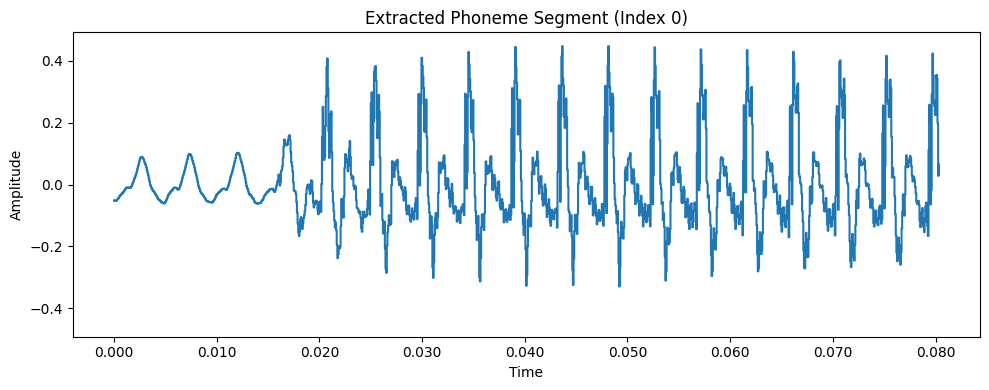

In [ ]:
plt.figure(figsize=(10, 4))
librosa.display.waveshow(phoneme_segment, sr=sample_rate)
plt.title(f"Extracted Phoneme Segment (Index {phoneme_index})")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()


In [ ]:
print("""
Inference:
- Vowels generally have smooth, periodic waveforms (voiced sounds).
- Consonants like /s/, /t/ show noisy or burst-like patterns.
- The extracted phoneme waveform characteristics indicate
  whether the source is voiced (vocal cords vibration) or unvoiced.
""")



Inference:
- Vowels generally have smooth, periodic waveforms (voiced sounds).
- Consonants like /s/, /t/ show noisy or burst-like patterns.
- The extracted phoneme waveform characteristics indicate
  whether the source is voiced (vocal cords vibration) or unvoiced.

